In [1]:
!pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

2024-04-26 13:31:26.020000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 13:31:26.020121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 13:31:26.159544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
images = np.load("/kaggle/input/mnist-hw5/x_train_wr.npy")
audios = np.load("/kaggle/input/mnist-hw5/x_train_sp.npy")
labels = pd.read_csv("/kaggle/input/mnist-hw5/y_train.csv")

In [4]:
images = images.reshape((-1, 28 ,28, 1))
audios = audios.reshape(-1, 507, 1)
labels = labels["label"].values

class_names =['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

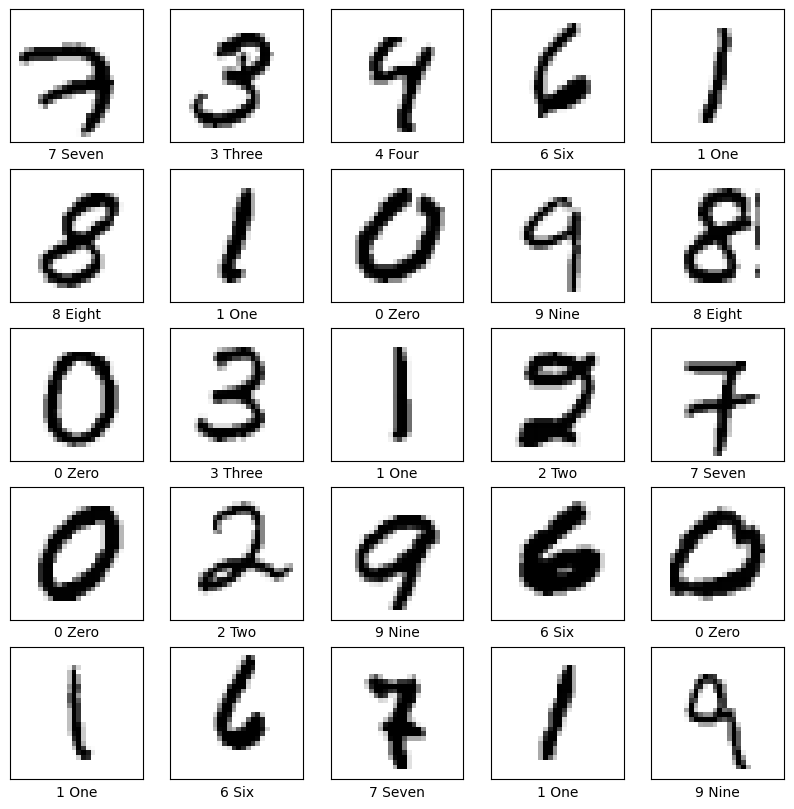

In [5]:
plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(images[i], cmap=plt.cm.binary)
  plt.xlabel("%s %s" % (labels[i], class_names[labels[i]]))

plt.show()

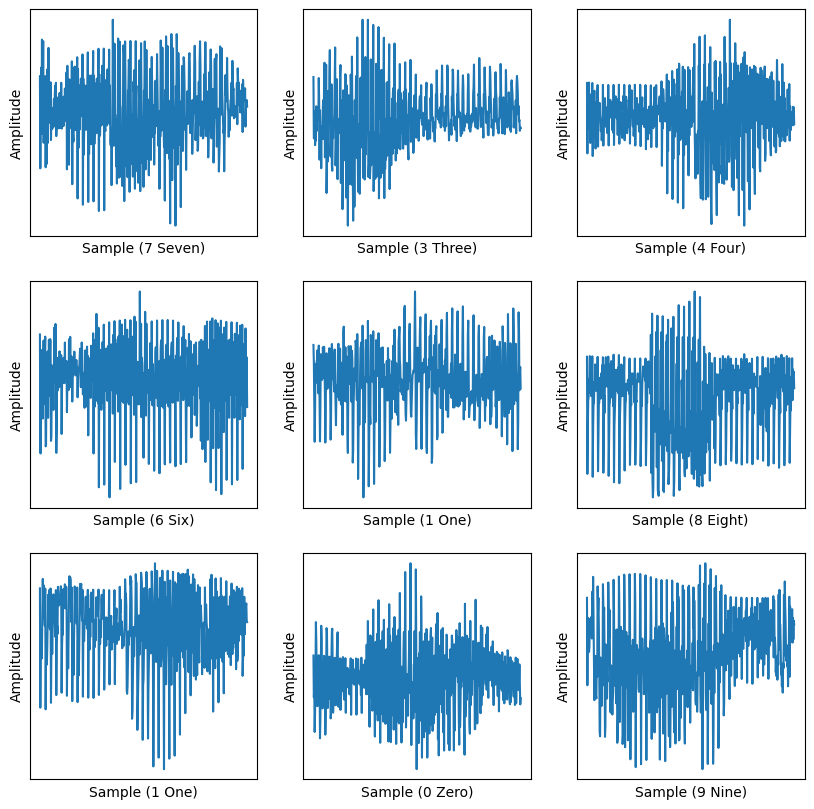

In [6]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(audios[i])
    plt.xlabel("Sample (%s %s)" % (labels[i], class_names[labels[i]]))
    plt.ylabel("Amplitude")

plt.show()

In [7]:
print("Train labels shape: %s and value: %s before one hot encoding" % (labels.shape, labels[0]))

labels_encoded = to_categorical(labels)

print("Train labels shape: %s and value: %s after one hot encoding" % (labels.shape, labels_encoded[0]))

Train labels shape: (60000,) and value: 7 before one hot encoding
Train labels shape: (60000,) and value: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] after one hot encoding


In [8]:
X_image_train, X_image_test, X_audio_train, X_audio_test, y_train, y_test = train_test_split(
    images, audios, labels_encoded, test_size=0.2, random_state=42
)

In [9]:
X_image_test, X_image_val, X_audio_test, X_audio_val, y_test, y_val = train_test_split(
    X_image_test, X_audio_test, y_test, test_size=0.5, random_state=42
)

In [10]:
def MultiModal(trial):
    image_encoder_input = Input(shape=(28, 28, 1), name="image_encoder_input")
    x = Conv2D(trial.suggest_int('image_filters_1', 16, 64, step=16), (3, 3), activation='relu')(image_encoder_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(trial.suggest_int('image_filter_2', 32, 128, step=32), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(trial.suggest_int('image_filters_3', 64, 256, step=64), (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    image_encoder_output = Flatten(name="image_embedding")(x)

    audio_encoder_input = Input(shape=(507, 1), name="audio_encoder_input")
    x = Conv1D(trial.suggest_int('audio_filters_1', 16, 64, step=16), 3, activation='relu')(audio_encoder_input)
    x = MaxPooling1D(2)(x)
    x = Conv1D(trial.suggest_int('audio_filters_2', 32, 128, step=32), 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(trial.suggest_int('audio_filters_3', 64, 256, step=64), 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    audio_encoder_output = Flatten(name="audio_embedding")(x)

    concatenated_features = concatenate([image_encoder_output, audio_encoder_output])

    x = Dense(trial.suggest_int('units', 32, 128, step=32), activation='relu')(concatenated_features)
    x = Dropout(trial.suggest_float('dropout', 0.1, 0.5))(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=[image_encoder_input, audio_encoder_input], outputs=predictions)

    model.compile(optimizer=Adam(trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
    model = MultiModal(trial)

    history = model.fit([X_image_train, X_audio_train], y_train, batch_size=128, epochs=10,
                        validation_data=([X_image_val, X_audio_val], y_val),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    metrics = model.evaluate([X_image_test, X_audio_test], y_test)
    return metrics[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
best_hyperparameters = best_trial.params

print("Best Hyperparameters:")
print(best_hyperparameters)

final_model = MultiModal(best_trial)
final_model.compile(optimizer=Adam(best_hyperparameters['learning_rate']),
                    loss='categorical_crossentropy', metrics=['accuracy'])
history = final_model.fit([X_image_train, X_audio_train], y_train, batch_size=128, epochs=10,
                          validation_data=([X_image_val, X_audio_val], y_val),
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

[I 2024-04-26 13:31:42,600] A new study created in memory with name: no-name-fdd174f8-a38d-4f72-b1e5-9923dedb60b1


Epoch 1/10
 13/375 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1512 - loss: 2.2660

I0000 00:00:1714138313.617316      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7701 - loss: 0.6838 - val_accuracy: 0.9660 - val_loss: 0.1183
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9746 - loss: 0.0837 - val_accuracy: 0.9820 - val_loss: 0.0526
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9880 - loss: 0.0409 - val_accuracy: 0.9878 - val_loss: 0.0423
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9909 - loss: 0.0282 - val_accuracy: 0.9783 - val_loss: 0.0820
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9917 - loss: 0.0249 - val_accuracy: 0.9868 - val_loss: 0.0444
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9941 - loss: 0.0173 - val_accuracy: 0.9833 - val_loss: 0.0577
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9864 - loss: 0.0487


[I 2024-04-26 13:32:27,947] Trial 0 finished with value: 0.987333357334137 and parameters: {'image_filters_1': 64, 'image_filter_2': 96, 'image_filters_3': 128, 'audio_filters_1': 64, 'audio_filters_2': 96, 'audio_filters_3': 128, 'units': 96, 'dropout': 0.15445594433191007, 'learning_rate': 0.002326249057448085}. Best is trial 0 with value: 0.987333357334137.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.3879 - loss: 1.6252 - val_accuracy: 0.9360 - val_loss: 0.2345
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8263 - loss: 0.4936 - val_accuracy: 0.9658 - val_loss: 0.1156
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8982 - loss: 0.2964 - val_accuracy: 0.9740 - val_loss: 0.0913
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9184 - loss: 0.2342 - val_accuracy: 0.9747 - val_loss: 0.0819
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9383 - loss: 0.1802 - val_accuracy: 0.9848 - val_loss: 0.0505
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9486 - loss: 0.1492 - val_accuracy: 0.9852 - val_loss: 0.0425
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9540 - loss: 0.1315 - val_accuracy: 0.9865 - val_loss: 0.0462
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9560 - loss: 0.1255 - val_acc

[I 2024-04-26 13:33:21,114] Trial 1 finished with value: 0.9863333106040955 and parameters: {'image_filters_1': 64, 'image_filter_2': 96, 'image_filters_3': 256, 'audio_filters_1': 32, 'audio_filters_2': 32, 'audio_filters_3': 256, 'units': 32, 'dropout': 0.3945208348629765, 'learning_rate': 0.0006194566632437328}. Best is trial 0 with value: 0.987333357334137.


Epoch 1/10


2024-04-26 13:33:24.989638: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.72417, expected 1.24375
2024-04-26 13:33:24.989697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.75364, expected 1.27322
2024-04-26 13:33:24.989712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.24359, expected 1.76317
2024-04-26 13:33:24.989729: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.39122, expected 1.91081
2024-04-26 13:33:24.989742: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.92485, expected 1.44444
2024-04-26 13:33:24.989753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.48974, expected 2.00933
2024-04-26 13:33:24.989764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.26792, expected 1.78751
2024-04-26 13:33:24.989774: E external/local_xla/xla/se

374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5276 - loss: 1.3119

2024-04-26 13:33:35.175105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.09788, expected 2.25304
2024-04-26 13:33:35.175169: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.35465, expected 1.50982
2024-04-26 13:33:35.175185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.34824, expected 1.50341
2024-04-26 13:33:35.175202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.31453, expected 1.46969
2024-04-26 13:33:35.175222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.55321, expected 2.70837
2024-04-26 13:33:35.175234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.6485, expected 2.80367
2024-04-26 13:33:35.175247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.19217, expected 2.34733
2024-04-26 13:33:35.175260: E external/local_xla/xla/ser

375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5286 - loss: 1.3091 - val_accuracy: 0.9450 - val_loss: 0.1798
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8956 - loss: 0.3228 - val_accuracy: 0.9592 - val_loss: 0.1492
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9262 - loss: 0.2397 - val_accuracy: 0.9603 - val_loss: 0.1513
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9498 - loss: 0.1688 - val_accuracy: 0.9658 - val_loss: 0.1265
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9611 - loss: 0.1350 - val_accuracy: 0.9625 - val_loss: 0.1528
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9608 - loss: 0.1323 - val_accuracy: 0.9690 - val_loss: 0.1261
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9640 - loss: 0.1258 - val_accuracy: 0.9713 - val_loss: 0.1274
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9687 - loss: 0.1082 - val_accuracy: 0.96

2024-04-26 13:34:18.755336: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.23455, expected 1.00508
2024-04-26 13:34:18.755394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.23285, expected 1.00338
2024-04-26 13:34:18.755405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 26: 1.20628, expected 0.976813
2024-04-26 13:34:18.755413: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27: 1.05634, expected 0.826866
2024-04-26 13:34:18.755421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 53: 1.18824, expected 0.95877
2024-04-26 13:34:18.755429: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98: 1.12336, expected 0.893891
2024-04-26 13:34:18.755437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 109: 1.05594, expected 0.82647
2024-04-26 13:34:18.755444: E external/local_x

165/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.5359

2024-04-26 13:34:19.875608: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 677: 1.93615, expected 1.54727
2024-04-26 13:34:19.875664: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 678: 1.93515, expected 1.54626
2024-04-26 13:34:19.875673: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 681: 2.836, expected 2.44712
2024-04-26 13:34:19.875681: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 686: 2.38662, expected 1.99773
2024-04-26 13:34:19.875689: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 687: 2.77131, expected 2.38243
2024-04-26 13:34:19.875697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 700: 2.81415, expected 2.42527
2024-04-26 13:34:19.875704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 701: 2.52469, expected 2.13581
2024-04-26 13:34:19.875712: E external/loca

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8368 - loss: 0.5350


[I 2024-04-26 13:34:20,621] Trial 2 finished with value: 0.8341666460037231 and parameters: {'image_filters_1': 16, 'image_filter_2': 32, 'image_filters_3': 128, 'audio_filters_1': 32, 'audio_filters_2': 96, 'audio_filters_3': 256, 'units': 64, 'dropout': 0.4429440512115794, 'learning_rate': 0.00448329620299367}. Best is trial 0 with value: 0.987333357334137.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5824 - loss: 1.2039 - val_accuracy: 0.9498 - val_loss: 0.1634
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9405 - loss: 0.2039 - val_accuracy: 0.9597 - val_loss: 0.1221
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9563 - loss: 0.1566 - val_accuracy: 0.9668 - val_loss: 0.1044
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9629 - loss: 0.1326 - val_accuracy: 0.9692 - val_loss: 0.1025
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9662 - loss: 0.1139 - val_accuracy: 0.9725 - val_loss: 0.0957
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9703 - loss: 0.1025 - val_accuracy: 0.9678 - val_loss: 0.1169
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9725 - loss: 0.1031 - val_accuracy: 0.9717 - val_loss: 0.0923
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9728 - loss: 0.0935 - val_acc

[I 2024-04-26 13:35:20,971] Trial 3 finished with value: 0.9711666703224182 and parameters: {'image_filters_1': 64, 'image_filter_2': 64, 'image_filters_3': 128, 'audio_filters_1': 64, 'audio_filters_2': 96, 'audio_filters_3': 128, 'units': 64, 'dropout': 0.3029100301942068, 'learning_rate': 0.005525457196821213}. Best is trial 0 with value: 0.987333357334137.


Epoch 1/10


2024-04-26 13:35:24.806169: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.91977, expected 1.24375
2024-04-26 13:35:24.806230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.94925, expected 1.27322
2024-04-26 13:35:24.806247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.43919, expected 1.76317
2024-04-26 13:35:24.806261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.58683, expected 1.91081
2024-04-26 13:35:24.806271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.12046, expected 1.44444
2024-04-26 13:35:24.806281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.68535, expected 2.00933
2024-04-26 13:35:24.806292: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.46353, expected 1.78751
2024-04-26 13:35:24.806302: E external/local_xla/xla/se

373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5693 - loss: 1.2599

2024-04-26 13:35:35.044833: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 676: 3.11653, expected 2.37057
2024-04-26 13:35:35.044896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 677: 2.51926, expected 1.77329
2024-04-26 13:35:35.044912: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 678: 2.60784, expected 1.86187
2024-04-26 13:35:35.044929: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 679: 2.50105, expected 1.75508
2024-04-26 13:35:35.044941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 680: 3.57404, expected 2.82808
2024-04-26 13:35:35.044951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 681: 3.26151, expected 2.51554
2024-04-26 13:35:35.044962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 682: 3.07373, expected 2.32777
2024-04-26 13:35:35.044973: E external/lo

375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5710 - loss: 1.2551 - val_accuracy: 0.9483 - val_loss: 0.1591
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9576 - loss: 0.1419 - val_accuracy: 0.9702 - val_loss: 0.0889
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9739 - loss: 0.0841 - val_accuracy: 0.9783 - val_loss: 0.0623
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9838 - loss: 0.0516 - val_accuracy: 0.9843 - val_loss: 0.0493
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9874 - loss: 0.0410 - val_accuracy: 0.9840 - val_loss: 0.0456
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9896 - loss: 0.0316 - val_accuracy: 0.9857 - val_loss: 0.0444
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9927 - loss: 0.0231 - val_accuracy: 0.9858 - val_loss: 0.0423
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9941 - loss: 0.0173 - val_accuracy: 0.97

2024-04-26 13:36:18.658398: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.35363, expected 1.53764
2024-04-26 13:36:18.658457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.82107, expected 1.00508
2024-04-26 13:36:18.658466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.81936, expected 1.00338
2024-04-26 13:36:18.658474: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.23827, expected 1.42229
2024-04-26 13:36:18.658491: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.05481, expected 2.23883
2024-04-26 13:36:18.658499: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.58554, expected 1.76955
2024-04-26 13:36:18.658507: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.00002, expected 2.18403
2024-04-26 13:36:18.658514: E external/local_xla/xla/se

163/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0416

2024-04-26 13:36:19.799043: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.34972, expected 1.00161
2024-04-26 13:36:19.799107: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.6774, expected 1.32929
2024-04-26 13:36:19.799124: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.95868, expected 1.61057
2024-04-26 13:36:19.799142: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.69333, expected 1.34521
2024-04-26 13:36:19.799156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.08558, expected 1.73747
2024-04-26 13:36:19.799167: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.59326, expected 1.24515
2024-04-26 13:36:19.799178: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.72639, expected 1.37827
2024-04-26 13:36:19.799189: E external/local_xla/xla/ser

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9894 - loss: 0.0421


[I 2024-04-26 13:36:20,545] Trial 4 finished with value: 0.9881666898727417 and parameters: {'image_filters_1': 32, 'image_filter_2': 64, 'image_filters_3': 64, 'audio_filters_1': 48, 'audio_filters_2': 64, 'audio_filters_3': 256, 'units': 96, 'dropout': 0.12272712004674445, 'learning_rate': 0.0006734303793936009}. Best is trial 4 with value: 0.9881666898727417.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6644 - loss: 0.9960 - val_accuracy: 0.9550 - val_loss: 0.1438
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9565 - loss: 0.1509 - val_accuracy: 0.9772 - val_loss: 0.0713
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9785 - loss: 0.0744 - val_accuracy: 0.9797 - val_loss: 0.0639
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9867 - loss: 0.0441 - val_accuracy: 0.9850 - val_loss: 0.0493
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9893 - loss: 0.0332 - val_accuracy: 0.9885 - val_loss: 0.0396
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9912 - loss: 0.0274 - val_accuracy: 0.9875 - val_loss: 0.0429
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9933 - loss: 0.0209 - val_accuracy: 0.9878 - val_loss: 0.0409
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9949 - loss: 0.0158 - val_acc

[I 2024-04-26 13:37:16,332] Trial 5 finished with value: 0.9886666536331177 and parameters: {'image_filters_1': 48, 'image_filter_2': 96, 'image_filters_3': 128, 'audio_filters_1': 64, 'audio_filters_2': 128, 'audio_filters_3': 192, 'units': 32, 'dropout': 0.13514428812386348, 'learning_rate': 0.0013462340348967155}. Best is trial 5 with value: 0.9886666536331177.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.2447 - loss: 2.0821 - val_accuracy: 0.8312 - val_loss: 0.7512
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6875 - loss: 0.9160 - val_accuracy: 0.9038 - val_loss: 0.3806
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7896 - loss: 0.6279 - val_accuracy: 0.9282 - val_loss: 0.2516
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8338 - loss: 0.5080 - val_accuracy: 0.9450 - val_loss: 0.1910
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8604 - loss: 0.4231 - val_accuracy: 0.9510 - val_loss: 0.1588
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8810 - loss: 0.3710 - val_accuracy: 0.9568 - val_loss: 0.1433
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8924 - loss: 0.3333 - val_accuracy: 0.9622 - val_loss: 0.1241
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8980 - loss: 0.3079 - val_acc

[I 2024-04-26 13:38:14,619] Trial 6 finished with value: 0.9714999794960022 and parameters: {'image_filters_1': 64, 'image_filter_2': 128, 'image_filters_3': 64, 'audio_filters_1': 16, 'audio_filters_2': 128, 'audio_filters_3': 128, 'units': 32, 'dropout': 0.4954415818637703, 'learning_rate': 0.00012810613692243968}. Best is trial 5 with value: 0.9886666536331177.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3454 - loss: 1.7833 - val_accuracy: 0.9110 - val_loss: 0.3529
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7944 - loss: 0.6335 - val_accuracy: 0.9573 - val_loss: 0.1613
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8452 - loss: 0.4729 - val_accuracy: 0.9687 - val_loss: 0.1086
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8881 - loss: 0.3520 - val_accuracy: 0.9768 - val_loss: 0.0859
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9002 - loss: 0.3093 - val_accuracy: 0.9775 - val_loss: 0.0742
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9091 - loss: 0.2805 - val_accuracy: 0.9813 - val_loss: 0.0659
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9212 - loss: 0.2495 - val_accuracy: 0.9815 - val_loss: 0.0707
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9256 - loss: 0.2296 - val_acc

[I 2024-04-26 13:39:13,868] Trial 7 finished with value: 0.9860000014305115 and parameters: {'image_filters_1': 64, 'image_filter_2': 64, 'image_filters_3': 128, 'audio_filters_1': 64, 'audio_filters_2': 64, 'audio_filters_3': 192, 'units': 32, 'dropout': 0.4739337070437021, 'learning_rate': 0.00042661998946375837}. Best is trial 5 with value: 0.9886666536331177.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7832 - loss: 0.6425 - val_accuracy: 0.9735 - val_loss: 0.0873
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9772 - loss: 0.0779 - val_accuracy: 0.9720 - val_loss: 0.0928
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9818 - loss: 0.0612 - val_accuracy: 0.9788 - val_loss: 0.0739
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9848 - loss: 0.0503 - val_accuracy: 0.9707 - val_loss: 0.1114
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9842 - loss: 0.0532 - val_accuracy: 0.9765 - val_loss: 0.0940
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9899 - loss: 0.0349 - val_accuracy: 0.9760 - val_loss: 0.1156
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9727 - loss: 0.1201


[I 2024-04-26 13:39:48,565] Trial 8 finished with value: 0.9754999876022339 and parameters: {'image_filters_1': 16, 'image_filter_2': 128, 'image_filters_3': 256, 'audio_filters_1': 16, 'audio_filters_2': 32, 'audio_filters_3': 64, 'units': 128, 'dropout': 0.1384296748911508, 'learning_rate': 0.007668347993743605}. Best is trial 5 with value: 0.9886666536331177.


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6105 - loss: 1.1424 - val_accuracy: 0.9507 - val_loss: 0.1637
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9522 - loss: 0.1626 - val_accuracy: 0.9735 - val_loss: 0.0804
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9752 - loss: 0.0844 - val_accuracy: 0.9772 - val_loss: 0.0694
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9819 - loss: 0.0610 - val_accuracy: 0.9847 - val_loss: 0.0469
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9869 - loss: 0.0437 - val_accuracy: 0.9867 - val_loss: 0.0457
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9878 - loss: 0.0406 - val_accuracy: 0.9845 - val_loss: 0.0414
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9911 - loss: 0.0289 - val_accuracy: 0.9875 - val_loss: 0.0376
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9932 - loss: 0.0217 - val_acc

[I 2024-04-26 13:40:47,139] Trial 9 finished with value: 0.9925000071525574 and parameters: {'image_filters_1': 48, 'image_filter_2': 128, 'image_filters_3': 64, 'audio_filters_1': 64, 'audio_filters_2': 64, 'audio_filters_3': 128, 'units': 128, 'dropout': 0.42575812135669355, 'learning_rate': 0.0007634644833825922}. Best is trial 9 with value: 0.9925000071525574.


Best Hyperparameters:
{'image_filters_1': 48, 'image_filter_2': 128, 'image_filters_3': 64, 'audio_filters_1': 64, 'audio_filters_2': 64, 'audio_filters_3': 128, 'units': 128, 'dropout': 0.42575812135669355, 'learning_rate': 0.0007634644833825922}
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6005 - loss: 1.1516 - val_accuracy: 0.9627 - val_loss: 0.1230
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9569 - loss: 0.1445 - val_accuracy: 0.9738 - val_loss: 0.0793
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9751 - loss: 0.0840 - val_accuracy: 0.9830 - val_loss: 0.0572
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9833 - loss: 0.0575 - val_accuracy: 0.9850 - val_loss: 0.0468
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9875 - loss: 0.0415 - val_accuracy: 0.9843 - val_loss: 0.0504
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9895 - loss: 0.0342 - val_accuracy: 0.9

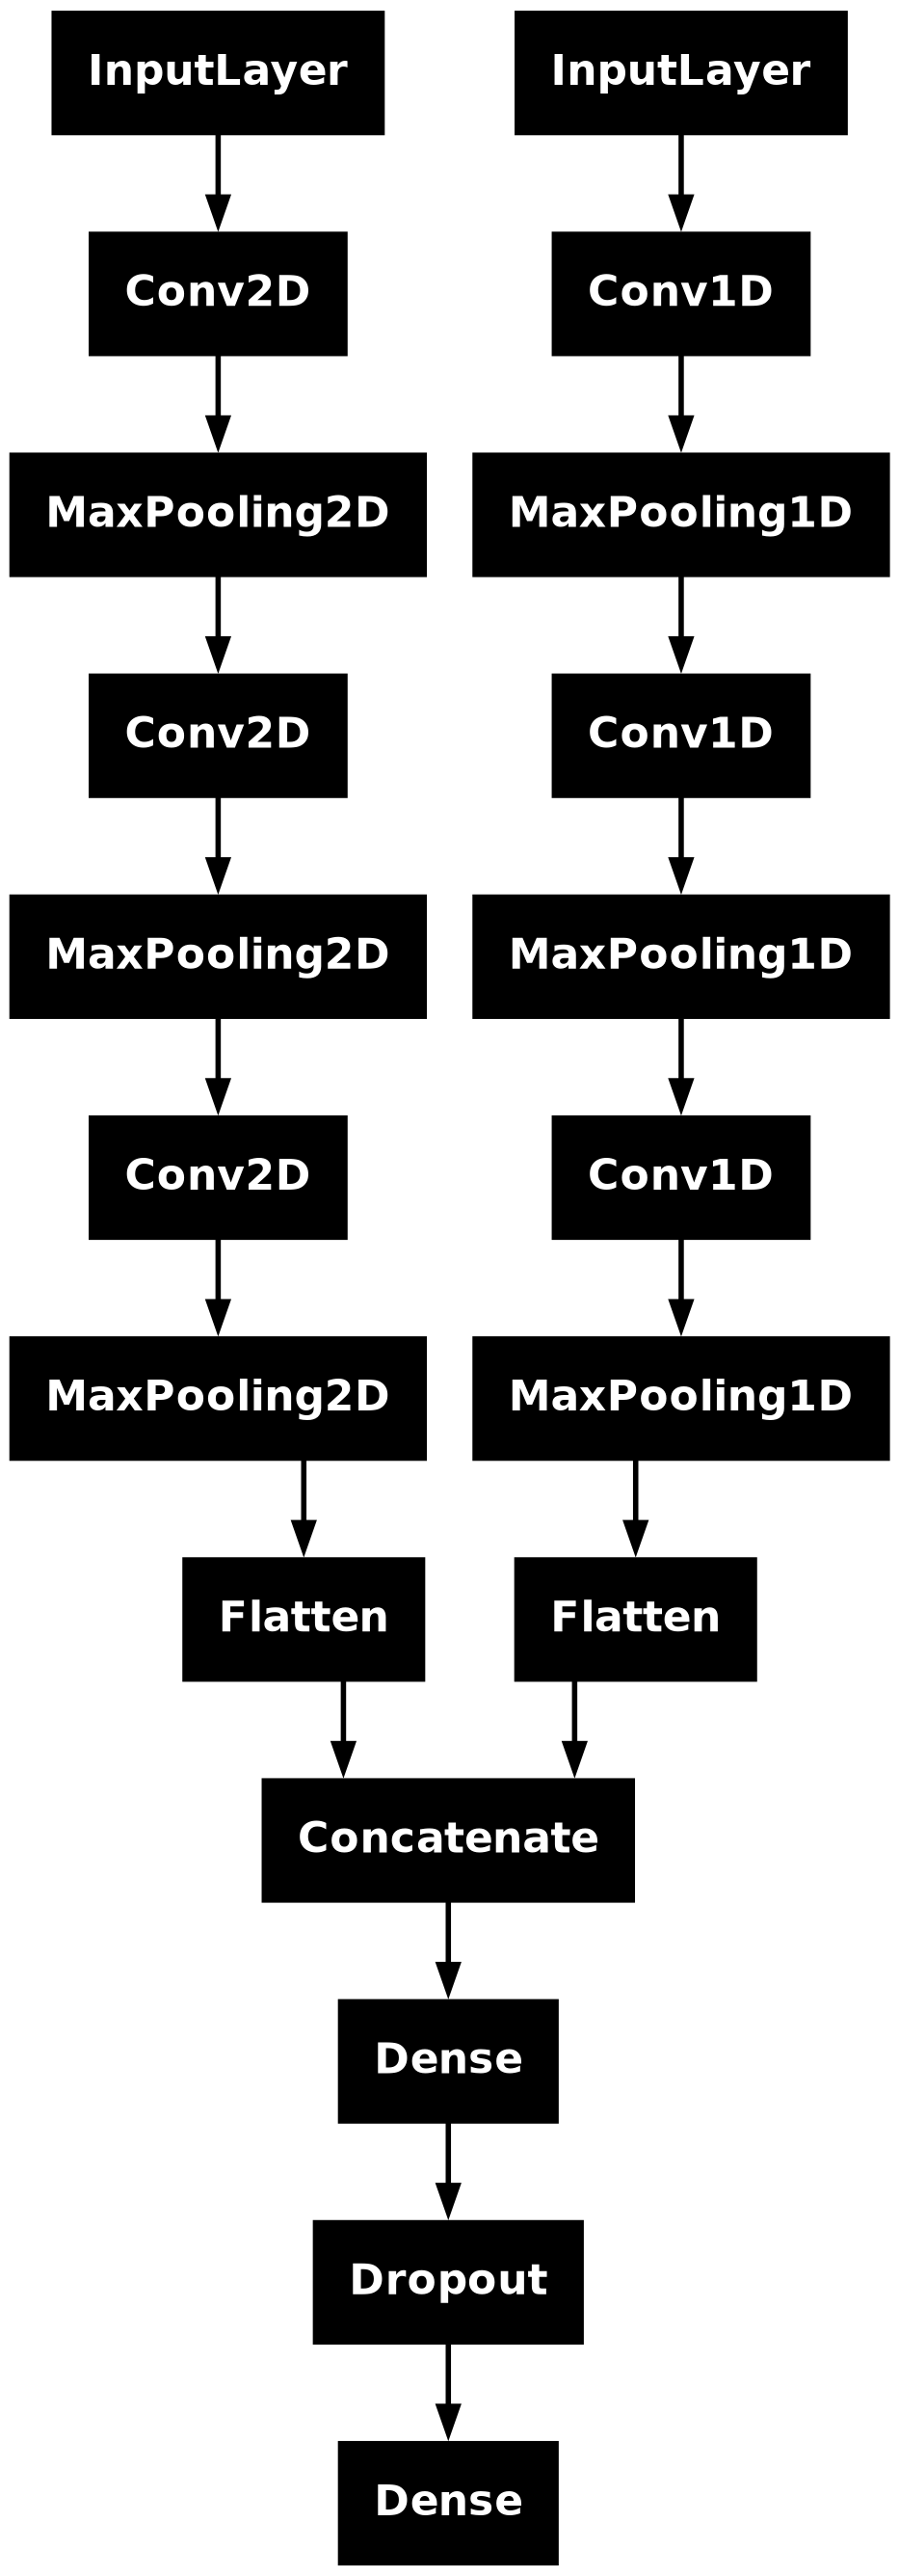

In [11]:
plot_model(final_model)

In [12]:
final_model.evaluate([X_image_test, X_audio_test], y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9911 - loss: 0.0334


[0.03578043729066849, 0.9893333315849304]

In [13]:
y_train_preds = final_model.predict([X_image_train, X_audio_train])
y_train_labels = np.argmax(y_train, axis=1)
y_train_preds_labels = np.argmax(y_train_preds, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [14]:
y_test_preds = final_model.predict([X_image_test, X_audio_test])
y_test_labels = np.argmax(y_test, axis=1)
y_test_preds_labels = np.argmax(y_test_preds, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [15]:
train_accuracy = accuracy_score(y_train_labels, y_train_preds_labels)
test_accuracy = accuracy_score(y_test_labels, y_test_preds_labels)

print(f"Accuracy on training set: {train_accuracy:.4f}")
print(f"Accuracy on testing set: {test_accuracy:.4f}")

Accuracy on training set: 0.9974
Accuracy on testing set: 0.9893


In [16]:
train_f1 = f1_score(y_train_labels, y_train_preds_labels, average="macro")
test_f1 = f1_score(y_test_labels, y_test_preds_labels, average="macro")

print(f"F1 score on training set: {train_f1:.4f}")
print(f"F1 score on testing set: {test_f1:.4f}")

F1 score on training set: 0.9974
F1 score on testing set: 0.9893


In [17]:
X_image_submission = np.load("/kaggle/input/mnist-hw5/x_test_wr.npy").reshape((-1, 28 ,28, 1))
X_audio_submission = np.load("/kaggle/input/mnist-hw5/x_test_sp.npy").reshape((-1, 507, 1))

In [18]:
y_submission_preds = final_model.predict([X_image_submission, X_audio_submission])
y_submission_preds_labels = np.argmax(y_submission_preds, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [19]:
row_ids = np.arange(len(y_submission_preds_labels))

submission = pd.DataFrame({
    'row_id': row_ids,
    'Label': y_submission_preds_labels,
})

submission.to_csv('submissions.csv', index=False)

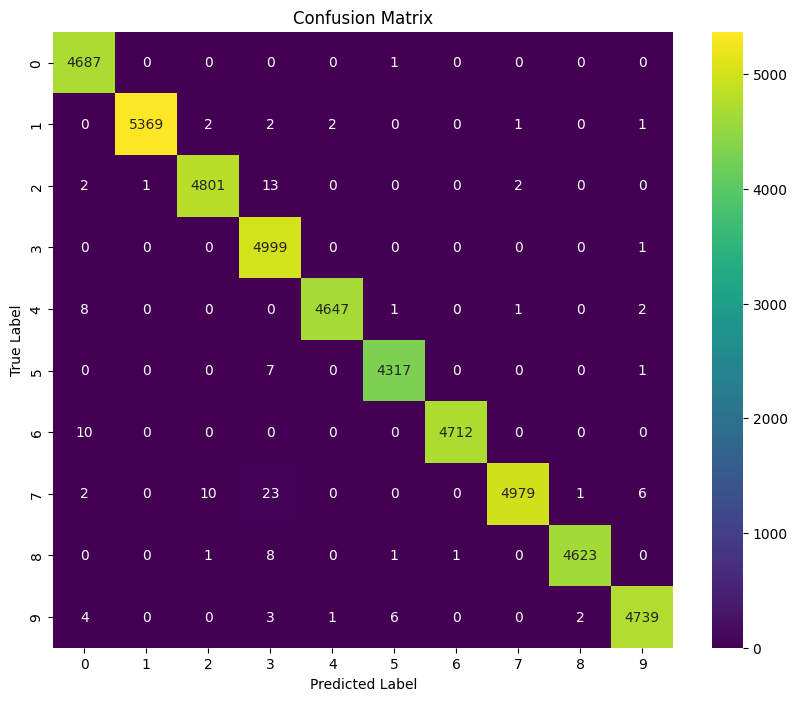

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for true labels and predicted labels
conf_matrix = confusion_matrix(y_train_labels, y_train_preds_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [21]:
image_embedding_extractor = Model(inputs=final_model.input, outputs=final_model.get_layer("image_embedding").output)
audio_embedding_extractor = Model(inputs=final_model.input, outputs=final_model.get_layer("audio_embedding").output)

In [22]:
image_embedding = image_embedding_extractor.predict([X_image_train, X_audio_train])
audio_embedding = audio_embedding_extractor.predict([X_image_train, X_audio_train])

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [23]:
tsne = TSNE(n_components=2, random_state=42)
im_reduced_embeddings = tsne.fit_transform(image_embedding)

In [24]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
i_cluster_labels = kmeans.fit_predict(im_reduced_embeddings)

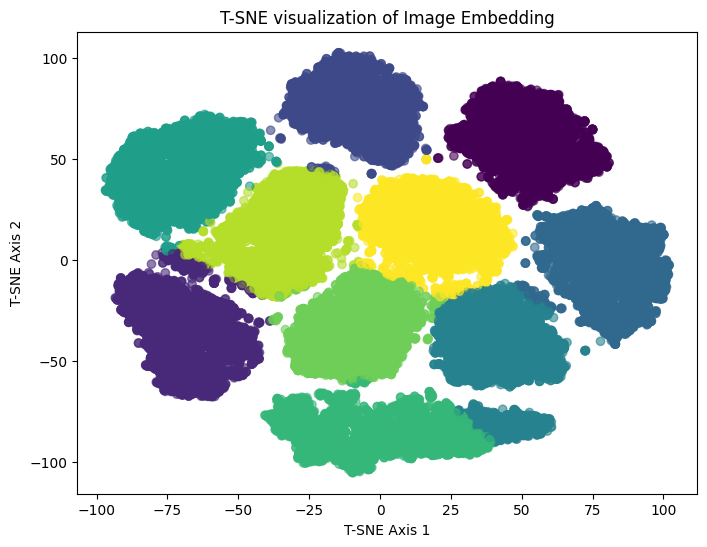

In [25]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(im_reduced_embeddings[:, 0], im_reduced_embeddings[:, 1], c=i_cluster_labels, cmap='viridis', alpha=0.6)
plt.title('T-SNE visualization of Image Embedding')
plt.xlabel('T-SNE Axis 1')
plt.ylabel('T-SNE Axis 2')
plt.show()

In [26]:
au_reduced_embeddings = tsne.fit_transform(audio_embedding)

In [27]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
a_cluster_labels = kmeans.fit_predict(au_reduced_embeddings)

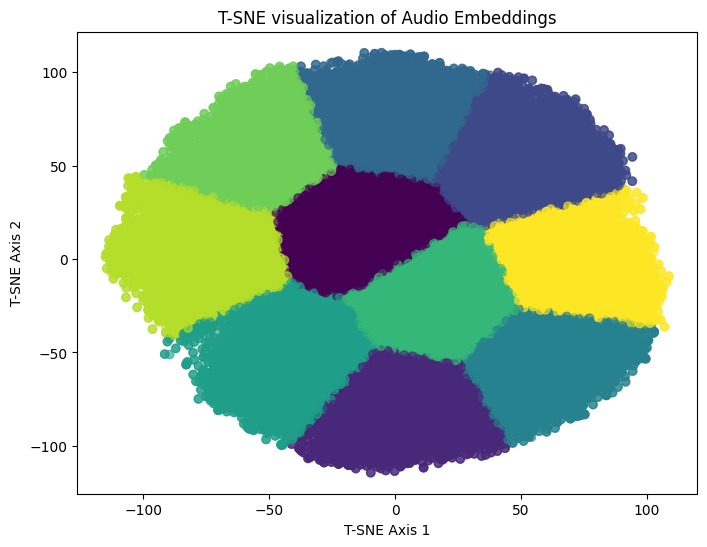

In [28]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(au_reduced_embeddings[:, 0], au_reduced_embeddings[:, 1], c=a_cluster_labels, cmap='viridis', alpha=0.6)
plt.title('T-SNE visualization of Audio Embeddings')
plt.xlabel('T-SNE Axis 1')
plt.ylabel('T-SNE Axis 2')
plt.show()

In [29]:
combined_embedding = np.concatenate([image_embedding, audio_embedding], axis=1)
reduced_embeddings = tsne.fit_transform(combined_embedding)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(combined_embedding)

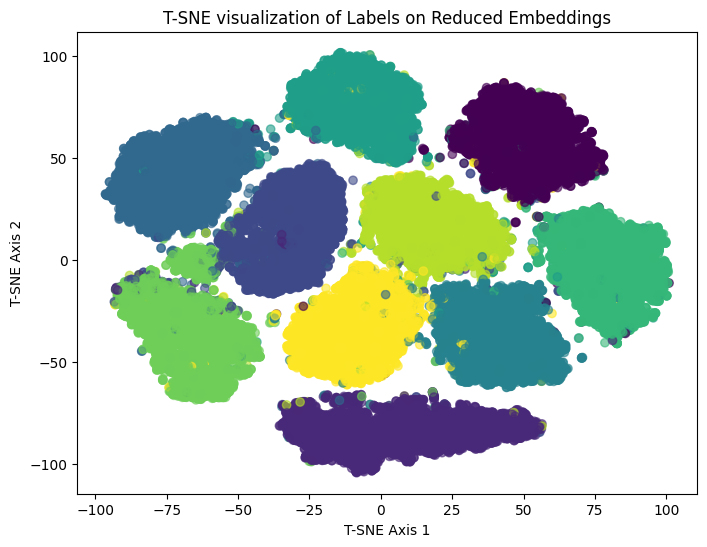

In [30]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train_labels, cmap='viridis', alpha=0.6)
plt.title('T-SNE visualization of Labels on Reduced Embeddings')
plt.xlabel('T-SNE Axis 1')
plt.ylabel('T-SNE Axis 2')
plt.show()

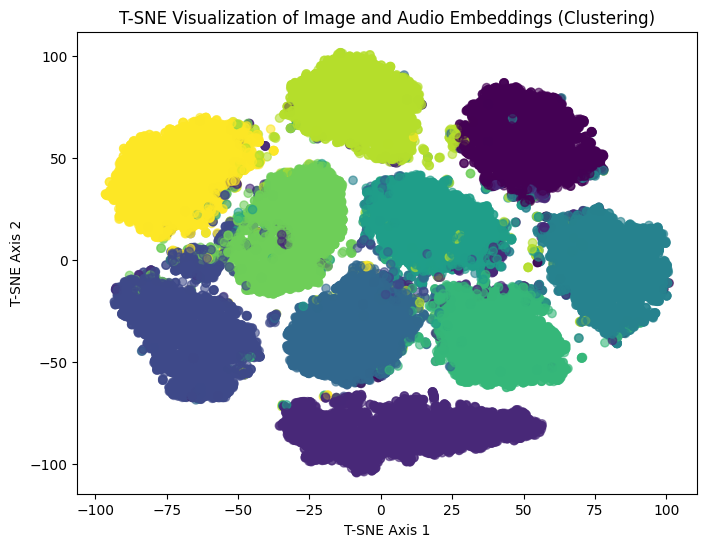

In [31]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('T-SNE Visualization of Image and Audio Embeddings (Clustering)')
plt.xlabel('T-SNE Axis 1')
plt.ylabel('T-SNE Axis 2')
plt.show()